# LSTM model

### Imports

In [1]:
# Basic Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint
import yfinance as yf

# Deep Learning / Machine Learning Imoprts
import random
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import plot_confusion_matrix 
import itertools
from sklearn.metrics import plot_roc_curve, roc_auc_score
from sklearn.metrics import roc_curve, auc
from keras.wrappers.scikit_learn import KerasClassifier
from statsmodels import *
from scipy.stats import *
from arch import arch_model
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from tabulate import tabulate
from numpy.random import seed

# ----------------------------------------------------------------------------------------

# Load CSV File

In [2]:
# From 16.08.2007 to 26.04.2022
bco = pd.read_csv('/Users/romaindeleze/Desktop/BSc/Romain_WI_TZ/8.Semester/BA/Daten/Brent_Crude_Oil')

In [3]:
bco.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3641 entries, 0 to 3640
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Date         3641 non-null   object 
 1   Close        3641 non-null   float64
 2   Log_Returns  3641 non-null   float64
 3   Pred_Signal  3641 non-null   int64  
 4   RSI          3641 non-null   float64
 5   K_percent    3641 non-null   float64
 6   MACD         3641 non-null   float64
 7   ROC          3641 non-null   float64
dtypes: float64(6), int64(1), object(1)
memory usage: 227.7+ KB


## Plot price history Close

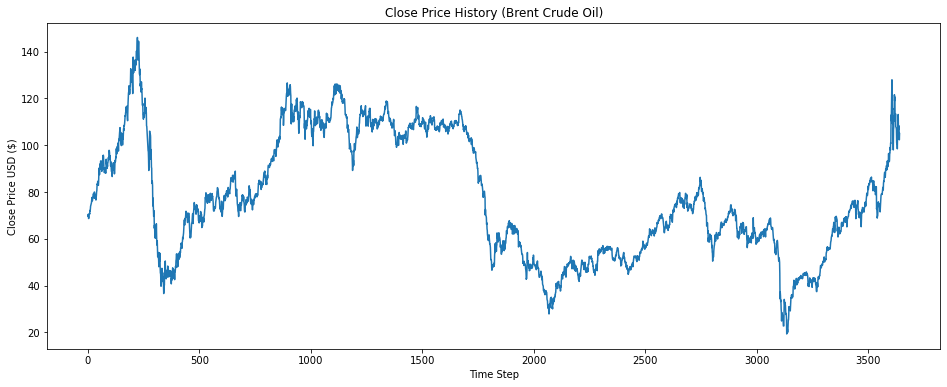

In [4]:
plt.figure(figsize=(16,6))
plt.title('Close Price History (Brent Crude Oil)')
plt.plot(bco['Close'])
plt.xlabel('Time Step')
plt.ylabel('Close Price USD ($)')
plt.show()

# ----------------------------------------------------------------------------------------

## Fit a GARCH(1,1) Model to see how many lags are needet to explain t+1

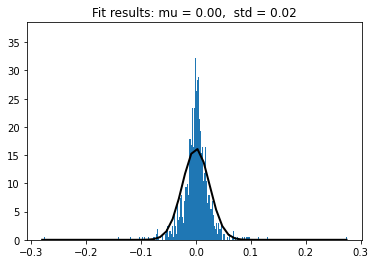

In [5]:
#Lets check the distribution of the data
import scipy
# Generate some data for this demonstration.
data = bco['Log_Returns']

# Fit a normal distribution to the data:
mu, std = scipy.stats.norm.fit(data)

# Plot the histogram.
plt.hist(data, bins=1000, density=True)

# Plot the PDF.
xmin, xmax = np.min(data), np.max(data)
x = np.linspace(xmin, xmax)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
plt.title(title)

plt.show()

In [6]:
# Defining the Model
garch_model = arch_model(bco['Log_Returns'], mean = "Zero", vol="GARCH", p=1, q=1, dist='t')

# Fitting the Model
garch_model_results = garch_model.fit()

# Printing the model summary
print(garch_model_results.summary())

Iteration:      1,   Func. Count:      5,   Neg. LLF: -9213.148204331432
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9213.148204396279
            Iterations: 5
            Function evaluations: 5
            Gradient evaluations: 1
                          Zero Mean - GARCH Model Results                           
Dep. Variable:                  Log_Returns   R-squared:                       0.000
Mean Model:                       Zero Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:                9213.15
Distribution:      Standardized Student's t   AIC:                          -18418.3
Method:                  Maximum Likelihood   BIC:                          -18393.5
                                              No. Observations:                 3641
Date:                      Wed, Jun 01 2022   Df Residuals:                     3641
Time:                              15:09

/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006077. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


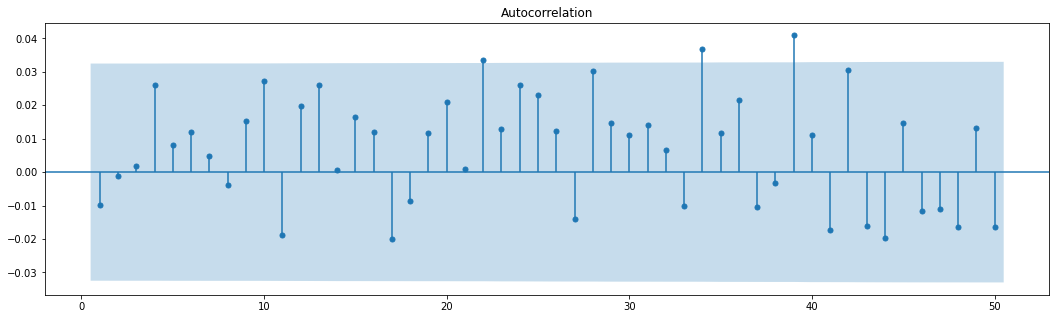

In [7]:
# Fixing plot size
plt.rcParams["figure.figsize"] = 18, 5

# Calculate standardized residuals
standard_residuals = garch_model_results.resid/garch_model_results.conditional_volatility

# Plot ACF of the stanadtized residuals
plot_acf(standard_residuals, zero = False, lags = 50)

plt.show()

In [8]:
garch_model_results.resid

0      -0.026449
1       0.009557
2      -0.008411
3      -0.016746
4       0.000145
          ...   
3636   -0.004205
3637    0.014224
3638   -0.015630
3639   -0.041447
3640    0.025760
Name: resid, Length: 3641, dtype: float64

# Building the Long Short Term Memory Model
##### We have split our data into a training set and testing set, so we need to identify our input which are the following:
##### Close price
##### We have to split the Close Price in a train and test dataset. For the LSTM algorithm we creat laged datasets so that we have a kind of a linear function who train the neural network. The LSTM creates the optimal parameters in each node to predict the next day with the past data.
#### For the LSTM model we are only interested in the Close column. We filter the Close column and save in a new object

In [9]:
# Create a new dataframe object with only the Close column 
data = bco.filter(['Close'])

# Extract only the values
close = data.values

# Creat object with the training data lenght
training_data_len = round(len(close)*0.8)

# Backtesting the lenghts
print('Lenght of the Whole dataset = ',len(close))
print('Training data lenght = ',training_data_len)
print('Test data lenght = ',len(close)-training_data_len)
print(training_data_len,' + ',len(close)-training_data_len,' = ', training_data_len + len(close)-training_data_len)

Lenght of the Whole dataset =  3641
Training data lenght =  2913
Test data lenght =  728
2913  +  728  =  3641


#### For better results we have to scale the dataset with the MinMaxScaler(). This is a function who Scale the values between 0 and 1.   

In [10]:
# We sacale the data with the MinMaxSacaler in values between 0 and 1
scaler = MinMaxScaler(feature_range=(0,1)) 
scaled_data = scaler.fit_transform(close)
scaled_data

array([[0.39794869],
       [0.40323473],
       [0.39857986],
       ...,
       [0.68891519],
       [0.65475344],
       [0.67581851]])

In [11]:
# Transform the sacled data in a data frame
df = pd.DataFrame(scaled_data, columns=['Scaled_Close'])
df.head()

,Scaled_Close
0,0.397949
1,0.403235
2,0.398580
3,0.389428
4,0.389507


In [12]:
# Lag Data
def buildLaggedFeatures(s,lag=2,dropna=True):
    
    if type(s) is pd.DataFrame:
        new_dict={}
        for col_name in s:
            new_dict[col_name]=s[col_name]
            # create lagged Series
            for l in range(1,lag+1):
                new_dict['%s_lag%d' %(col_name,l)]=s[col_name].shift(l)
        res=pd.DataFrame(new_dict,index=s.index)

    elif type(s) is pd.Series:
        the_range=range(lag+1)
        res=pd.concat([s.shift(i) for i in the_range],axis=1)
        res.columns=['lag_%d' %i for i in the_range]
    else:
        print('Only works for DataFrame or Series')
        return None
    if dropna:
        return res.dropna()
    else:
        return res 

res=buildLaggedFeatures(df,lag=39,dropna=False)

# Drop all columns with NA values
res = res.dropna()

res.head()

,Scaled_Close,Scaled_Close_lag1,Scaled_Close_lag2,Scaled_Close_lag3,Scaled_Close_lag4,Scaled_Close_lag5,Scaled_Close_lag6,Scaled_Close_lag7,Scaled_Close_lag8,Scaled_Close_lag9,...,Scaled_Close_lag30,Scaled_Close_lag31,Scaled_Close_lag32,Scaled_Close_lag33,Scaled_Close_lag34,Scaled_Close_lag35,Scaled_Close_lag36,Scaled_Close_lag37,Scaled_Close_lag38,Scaled_Close_lag39
39,0.479842,0.467613,0.458856,0.451677,0.469980,0.470533,0.457988,0.457988,0.460039,0.472110,...,0.416568,0.404103,0.407258,0.404655,0.398659,0.389507,0.389428,0.398580,0.403235,0.397949
40,0.482998,0.479842,0.467613,0.458856,0.451677,0.469980,0.470533,0.457988,0.457988,0.460039,...,0.414753,0.416568,0.404103,0.407258,0.404655,0.398659,0.389507,0.389428,0.398580,0.403235
41,0.500355,0.482998,0.479842,0.467613,0.458856,0.451677,0.469980,0.470533,0.457988,0.457988,...,0.420986,0.414753,0.416568,0.404103,0.407258,0.404655,0.398659,0.389507,0.389428,0.398580
42,0.506667,0.500355,0.482998,0.479842,0.467613,0.458856,0.451677,0.469980,0.470533,0.457988,...,0.430690,0.420986,0.414753,0.416568,0.404103,0.407258,0.404655,0.398659,0.389507,0.389428
43,0.503353,0.506667,0.500355,0.482998,0.479842,0.467613,0.458856,0.451677,0.469980,0.470533,...,0.434004,0.430690,0.420986,0.414753,0.416568,0.404103,0.407258,0.404655,0.398659,0.389507


In [13]:
# Split Data in X_train, X_test, y_train, y_test
#y_train = res[]

X = res.iloc[:,1:]
print(len(X))

y = res.iloc[:,0:1]
print(len(y))

# Split Features
X_train = X[:training_data_len]
X_test = X[training_data_len:]

# Split Label
y_train = y[:training_data_len]
y_test = y[training_data_len:]

3602
3602


In [14]:
# Convert the X_train and y_train to numpy arrays 
X_train, y_train = np.array(X_train), np.array(y_train)

# Reshape the data
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
# X_train.shape

# Convert the data to a numpy array
X_test = np.array(X_test)

# Reshape the data
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1 ))

# ----------------------------------------------------------------------------------------

# We build the LSTM model and use it to make the prediction

In [15]:
# Build the LSTM model
seed(8)
tf.random.set_seed(8)
def build_model():
    model = Sequential()
    model.add(LSTM(128, return_sequences=True, input_shape= (X_train.shape[1], 1)))
    model.add(LSTM(64, return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

model = build_model()
history = model.fit(X_train, y_train, batch_size=1, epochs=5)

# Get the models predicted price values 
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions) # back-transform Prediction 

Epoch 1/5
2913/2913 [==============================] - 35s 11ms/step - loss: 0.0063
Epoch 2/5
2913/2913 [==============================] - 36s 12ms/step - loss: 0.0037
Epoch 3/5
2913/2913 [==============================] - 33s 11ms/step - loss: 0.0030
Epoch 4/5
2913/2913 [==============================] - 34s 12ms/step - loss: 0.0019
Epoch 5/5
2913/2913 [==============================] - 36s 12ms/step - loss: 0.0016


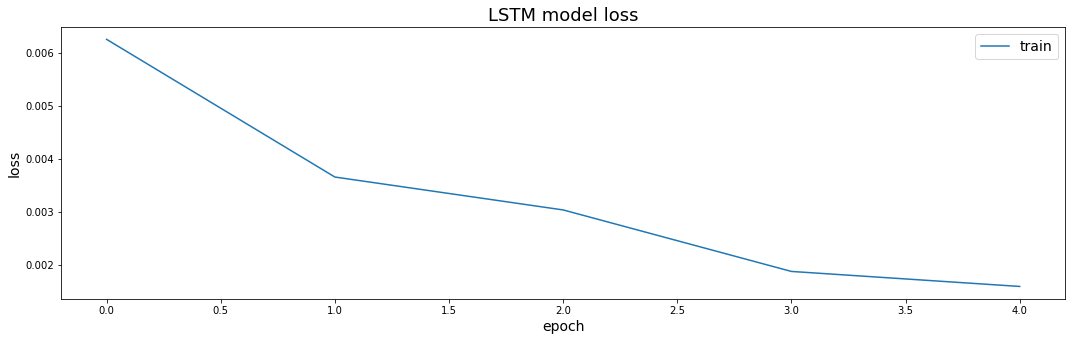

In [16]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.title('LSTM model loss', fontsize=18)
plt.ylabel('loss', fontsize=14)
plt.xlabel('epoch', fontsize=14)
plt.legend(['train', 'test'], loc='best', fontsize=14)
plt.show()

<ipython-input-17-ca7e21da7781>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Prediction'] = predictions


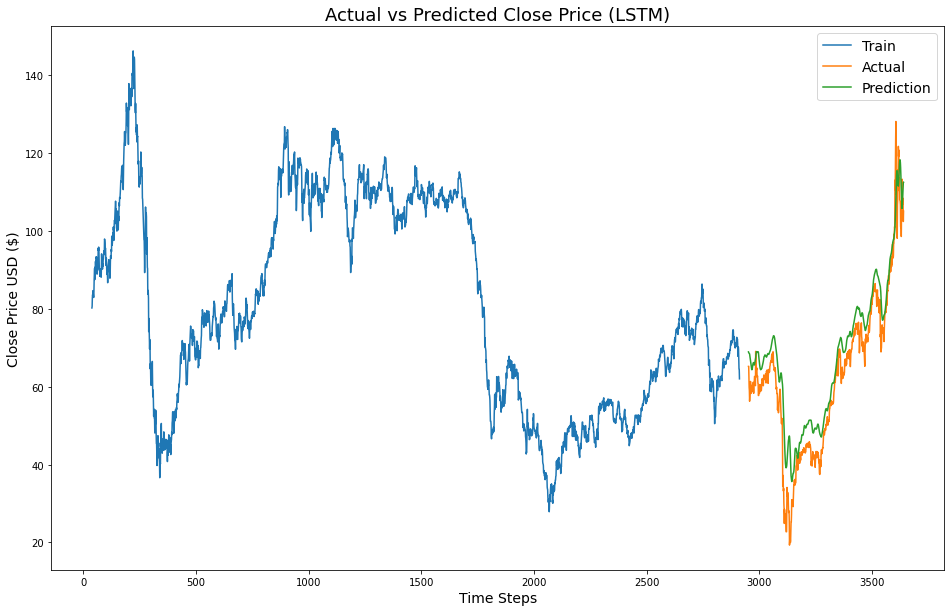

In [17]:
# Plot the data
train = data[X_train.shape[1]:training_data_len]
test = data[training_data_len+X_train.shape[1]:]
test['Prediction'] = predictions

# Visualize the data
plt.figure(figsize=(16,10))
plt.title('Actual vs Predicted Close Price (LSTM)', fontsize=18)
plt.xlabel('Time Steps', fontsize=14)
plt.ylabel('Close Price USD ($)', fontsize=14)
plt.plot(train['Close'])
plt.plot(test[['Close', 'Prediction']])
plt.legend(['Train', 'Actual', 'Prediction'], loc='best', fontsize=14)
plt.show()

In [18]:
# Transform real and predicted close price in a Signal

X_test = test['Close']
#print(X_test)
y_pred = test['Prediction']
#print(y_pred)

X_r = X_test.pct_change() # Real Returns in Test data
X1 = (X_r > 0).astype(int) # Real low risk Signal
#print(X)

y_r = y_pred.pct_change() # Predicted Returns from Test data
y1 = (y_r > 0).astype(int) # Predicted low risk Signal
#print(y1)

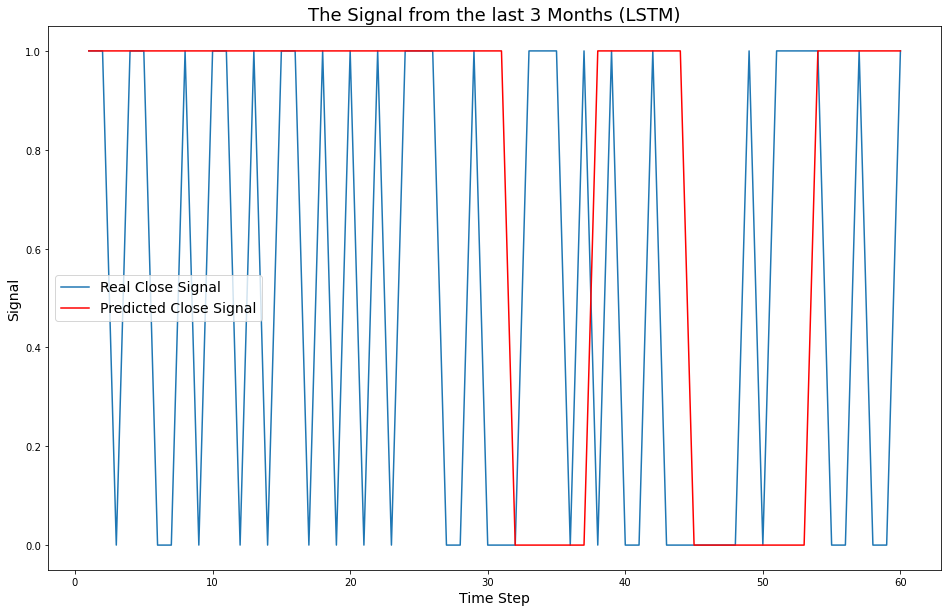

In [19]:
m3 = 3*4*5
x = np.linspace(1,m3,m3)
plt.figure(figsize=(16,10))
plt.title('The Signal from the last 3 Months (LSTM)', fontsize=18)
plt.plot(x,X1[len(X1)-m3:],label = 'Real Close Signal')
plt.plot(x,y1[len(y1)-m3:],color = 'red', label = 'Predicted Close Signal')
plt.ylabel('Signal', fontsize=14)
plt.xlabel('Time Step', fontsize=14)
plt.legend(loc='best', fontsize=14)

# ----------------------------------------------------------------------------------------

# Accuracy
##### We've built our model, so now we can see how accurate it is. SciKit learn, makes the process of evaluating our model very easy by providing a bunch of built-in metrics that we can call. One of those metrics is the accuracy_score. The accuracy_score function computes the accuracy, by calculating the sum of the correctly predicted signals and then dividing it by the total number of predictions. Imagine we had three TRUE values [1, 2, 3] , and our model predicted the following values [1, 2, 4] we would say the accuracy of our model is 2/3 = 66 % .

# AUC
##### AUC  curve is a performance measurement for the classification problems at various threshold settings. AUC represents the degree or measure of separability. It tells how much the model is capable of distinguishing between classes. Higher the AUC, the better the model is at predicting 0 classes as 0 and 1 classes as 1. By analogy, the Higher the AUC, the better the model is at distinguishing between patients with the disease and no disease.

# RMSE
##### Root Mean Square Error (RMSE) is the standard deviation of the residuals (prediction errors). Residuals are a measure of how far from the regression line data points are; RMSE is a measure of how spread out these residuals are. In other words, it tells you how concentrated the data is around the line of best fit. 

In [20]:
# Now we can compare the accuracy (Hit Ratio) from the prediction
print('Correct Prediction (Hit Ratio) in % : ', accuracy_score(X1, y1) * 100.0) # Hit Ratio low risk strategie!
print()

# Checking performance our model with AUC Score.
print('Area under the curve: ',roc_auc_score(X1, y1))
print()

# Get the root mean squared error (RMSE)
print('Close Price RMSE = ' ,np.sqrt(np.mean(((predictions - y_test) ** 2))))
print('Signal RMSE = ' ,np.sqrt(np.mean(((y1 - X1) ** 2))))

Correct Prediction (Hit Ratio) in % :  51.814223512336724

Area under the curve:  0.50670307422719

Close Price RMSE =  Scaled_Close    70.170485
dtype: float64
Signal RMSE =  0.6941597545786077


# ----------------------------------------------------------------------------------------

# Classification Report
##### To get a more detailed overview of how the model performed, we can build a classification report that will compute the F1_Score , the Precision , the Recall , and the Support .

### Precision
##### Precision measures the proportion of all correctly identified samples in a population of samples which are classified as positive labels and is defined as the following:
##### tp = True Positiv
##### fp = False Positiv
##### Precision = tp/(tp+fp)
##### The precision is intuitively the ability of the classifier not to label as positive a sample that is negative. The best value is 1, and the worst value is 0.

### Recall
##### Recall (also known as sensitivity) measures the ability of a classifier to correctly identify positive labels and is defined as the following:
##### tp = True Positiv
##### fn = False Negativ
##### Recall = tp/(tp+fn)
##### The recall is intuitively the ability of the classifier to find all the positive samples. The best value is 1, and the worst value is 0.

### Support
##### Support is the number of actual occurrences of the class in the specified dataset. Imbalanced support in the training data may indicate structural weaknesses in the reported scores of the classifier and could indicate the need for stratified sampling or rebalancing. Support doesn’t change between models but instead diagnoses the evaluation process.

### F1 Score
##### In some cases, we will have models that may have low precision or high recall. It's difficult to compare two models with low precision and high recall or vice versa. To make results comparable, we use a metric called the F-Score. The F-score helps to measure Recall and Precision at the same time. It uses Harmonic Mean in place of Arithmetic Mean by punishing the extreme values more.
##### The traditional F-measure or balanced F-score (F1 score) is the harmonic mean of precision and recall:
##### tp = True Positiv
##### fp = False Positiv
##### fn = False Negativ
##### F1 Score = tp/(tp+0.5*(fp+fn))

In [21]:
# Define the traget names
target_names = ['Down Day', 'Up Day'] 

# Build a classifcation report
report = classification_report(y_true = X1, y_pred = y1, target_names = target_names, output_dict = True)

# Add it to a data frame, transpose it for readability.
report_df = pd.DataFrame(report).transpose() 
report_df

,precision,recall,f1-score,support
Down Day,0.460076,0.389068,0.421603,311.000000
Up Day,0.553991,0.624339,0.587065,378.000000
accuracy,0.518142,0.518142,0.518142,0.518142
macro avg,0.507033,0.506703,0.504334,689.000000
weighted avg,0.511600,0.518142,0.512379,689.000000


# ----------------------------------------------------------------------------------------

# Confusion Matrix
##### A confusion matrix is a technique for summarizing the performance of a classification algorithm. Classification accuracy alone can be misleading if you have an unequal number of observations in each class or if you have more than two classes in your dataset. Calculating a confusion matrix can give you a better idea of what your classification model is getting right and what types of errors it is making.

In [22]:
cm = confusion_matrix(X1, y1, normalize='pred')

In [23]:
# Function: Confusion Matrix Plot for Regression, Neural Network
def plot_confusion_matrix_regression(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 1.2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Accuracy: 0.51814
Percision: 0.62434
Recall: 0.55399
Specificity: 0.46008

Confusion matrix, without normalization
[[0.46  0.446]
 [0.54  0.554]]


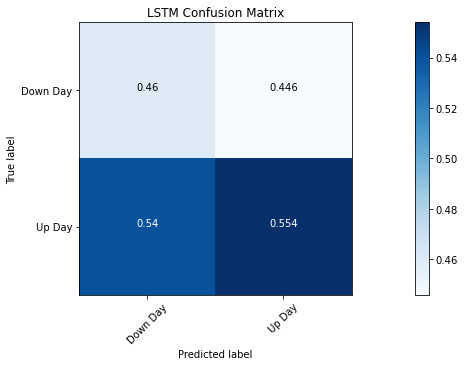

In [24]:
# Compute Confusion Matrix
LSTM_matrix = confusion_matrix(y1, X1)

# Save individual values
true_negatives = LSTM_matrix[0][0] 
false_negatives = LSTM_matrix[1][0] 
true_positives = LSTM_matrix[1][1] 
false_positives = LSTM_matrix[0][1]

# Compute performance values
accuracy = (true_negatives + true_positives) / (true_negatives + true_positives + false_negatives + false_positives) 
percision = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)
specificity = true_negatives / (true_negatives + false_positives)

# Print values
print('Accuracy: {}'.format(round(float(accuracy),5))) 
print('Percision: {}'.format(round(float(percision),5)) )
print('Recall: {}'.format(round(float(recall),5)) )
print('Specificity: {}'.format(round(float(specificity),5)))
print()

# Visualise the Confusion Matrix 
cm_plot_labels = ['Down Day','Up Day']
disp = plot_confusion_matrix_regression(cm=np.round(cm,3), classes=cm_plot_labels, title='LSTM Confusion Matrix',
                               normalize=False)

### With the information from the confusion matrix we want know now how the proportion is. 
#### How is the prediction distributed, and how ist the real values distributed

In [25]:
# Propotion of the real values
unique, counts = np.unique(X1, return_counts=True)
print('Real Proportion')
print(dict(zip(unique, counts/len(X1))))
print()

# Propotion of the predicted values
unique, counts = np.unique(y1, return_counts=True)
print('Predicted Proportion')
print(dict(zip(unique, counts/len(y1))))

Real Proportion
{0: 0.4513788098693759, 1: 0.548621190130624}

Predicted Proportion
{0: 0.38171262699564584, 1: 0.6182873730043541}


#### We see that the model predicted very well the propotion of the two class

# ----------------------------------------------------------------------------------------

# ROC Curve
##### The Receiver Operating Characteristic is a graphical method to evaluate the performance of a binary classifier. A curve is drawn by plotting True Positive Rate (sensitivity) against False Positive Rate (1 - specificity) at various threshold values. ROC curve shows the trade-off between sensitivity and specificity. When the curve comes closer to the left-hand border and the top border of the ROC space, it indicates that the test is accurate. The closer the curve is to the top and left-hand border, the more accurate the test is. If the curve is close to the 45 degrees diagonal of the ROC space, it means that the test is not accurate. ROC curves can be used to select the optimal model and discard the suboptimal ones.

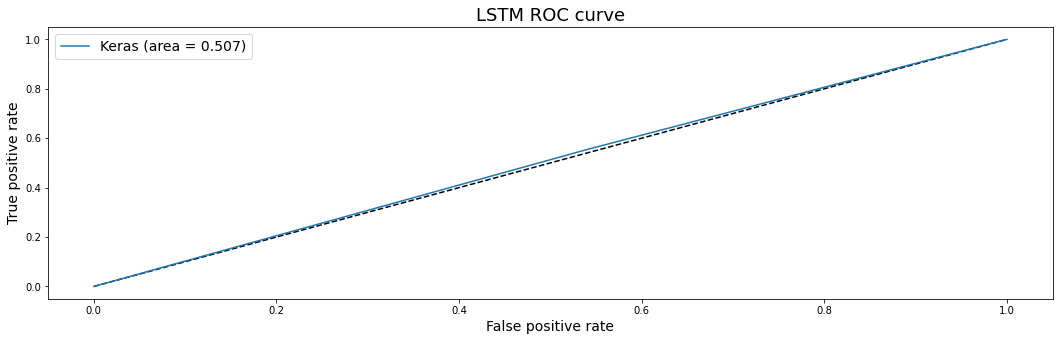

In [26]:
y_pred_Signal = y1
y_test_Signal = X1

fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_pred_Signal, y_test_Signal)

auc_keras = auc(fpr_keras, tpr_keras)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate', fontsize=14)
plt.ylabel('True positive rate', fontsize=14)
plt.title('LSTM ROC curve', fontsize=18)
plt.legend(loc='best', fontsize=14)
plt.show()

# ----------------------------------------------------------------------------------------

# Trading Performance 

In [27]:
n = len(y_pred)
X2 = bco['Log_Returns']
X2 = X2[len(X2)-n:]
len(X2)

689

## Long

In [28]:
perf = y1 * X2
perf = perf.dropna()

trading_days_Y = 5*52 

perf_sharpe = np.sqrt(trading_days_Y) * np.mean(perf) / (np.sqrt(np.var(perf)))

## Long-Short

In [29]:
perf1 = np.sign(y_r) * X2
perf1 = perf1.dropna()

trading_days_Y = 5*52 

perf_sharpe1 = np.sqrt(trading_days_Y) * np.mean(perf1) / (np.sqrt(np.var(perf1)))

## Buy and Hold

In [30]:
perf2 = X2
perf2 = perf2.dropna()

trading_days_Y = 5*52 

perf_sharpe2 = np.sqrt(trading_days_Y) * np.mean(perf2) / (np.sqrt(np.var(perf2)))

# Comparison ML vs. Buy and Hold

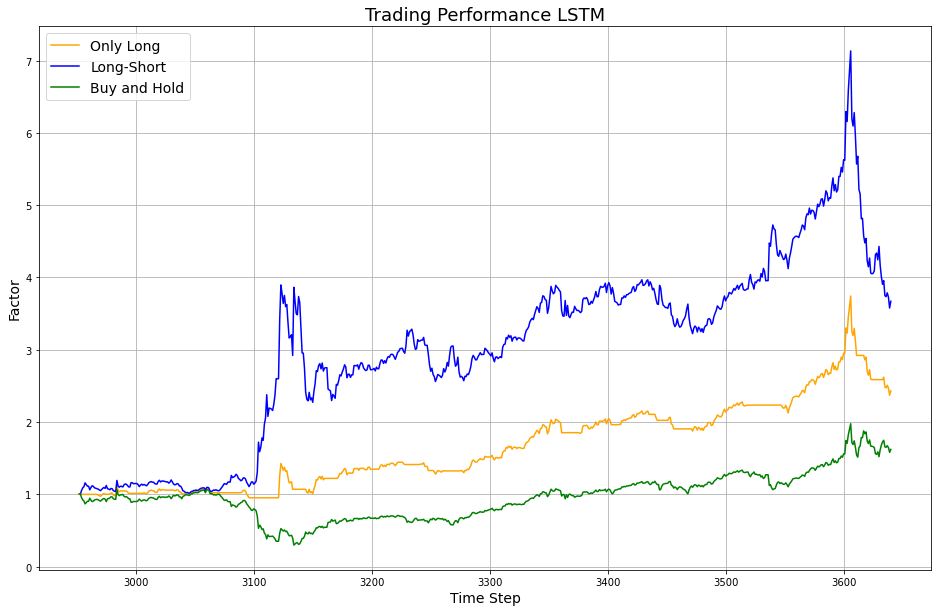

In [31]:
plt.figure(figsize=(16,10))
plt.title('Trading Performance LSTM', fontsize=18)
plt.ylabel('Factor', fontsize=14)
plt.xlabel('Time Step', fontsize=14)
plt.grid(True)
plt.plot(np.exp(perf).cumprod() , label='Only Long', color = 'orange')
plt.plot(np.exp(perf1).cumprod() , label='Long-Short', color = 'blue')
plt.plot(np.exp(perf2).cumprod() , label='Buy and Hold', color = 'green')
plt.legend(loc='best', fontsize=14)

# Profit Factor

In [32]:
L_profit = np.exp(perf).cumprod().iloc[-1]

LS_profit = np.exp(perf1).cumprod().iloc[-1]

BaH_profit = np.exp(perf2).cumprod().iloc[-1]

# Performance Table

In [33]:
#create data
data = [["Buy and Hold", round(perf_sharpe2,2), round(BaH_profit,2)], 
        ["Only Long", round(perf_sharpe,2), round(L_profit,2)], 
        ["Long Short", round(perf_sharpe1,2), round(LS_profit,2)]]
  
#define header names
col_names = ["Strategie", "Sharp Ratio", "Profit Factor"]
  
#display table
print('LSTM')
print(tabulate(data, headers=col_names))

LSTM
Strategie       Sharp Ratio    Profit Factor
------------  -------------  ---------------
Buy and Hold           0.33             1.62
Only Long              0.95             2.43
Long Short             0.89             3.67


In [34]:
# Performance Dataset
LSTM_Perf_OL = np.exp(perf).cumprod()
LSTM_Perf_LS = np.exp(perf1).cumprod()

LSTM_Perf_data = pd.DataFrame()
LSTM_Perf_data['LSTM_Perf_OL'] = LSTM_Perf_OL[:720]
LSTM_Perf_data['LSTM_Perf_LS'] = LSTM_Perf_LS

LSTM_Perf_data.to_csv('/Users/romaindeleze/Desktop/BSc/Romain_WI_TZ/8.Semester/BA/Daten/LSTM_Perf_data')

# Extrem and Regular Value Accuracy

In [36]:
# Creat Data Frame with Predicted Signal and Log Returns
n = len(y_pred)
X = bco['Log_Returns']
X = X[len(X)-n:]
y2 = np.squeeze(y1) # Dimension Reduction
d = {'Predicted Signal':y2.values, 'Log Returns':X.values}
df = pd.DataFrame(data=d)

# Creat the upperbound and the lowerbound
μ = np.mean(X)
σ = np.std(X)
lb = μ-2*σ
ub = μ+2*σ

# Creat Data Frame with only Values in the interval [lb,ub]
reg_val = df[(df['Log Returns'] >= lb) & (df['Log Returns'] <= ub)] # DataFrame with Regular Values = [lb,ub]
#print(len(reg_val))

# Creat Data Frame with only Values outside the interval [lb,ub]
ext_val = df.drop(index=reg_val.index)
#print(len(ext_val))

# Add real Signal with the Log Returns for each Data Frame
reg_val['Real Signal'] = (reg_val['Log Returns'] > 0).astype(int)
ext_val['Real Signal'] = (ext_val['Log Returns'] > 0).astype(int)
#print(reg_val)
#print(ext_val)

# Compute accuracy of the Extrem Values and the Regular Values
acc_reg = accuracy_score(reg_val['Real Signal'], reg_val['Predicted Signal'], normalize = True) * 100.0
acc_ext = accuracy_score(ext_val['Real Signal'], ext_val['Predicted Signal'], normalize = True) * 100.0
print('Accuracy Regular Values = ', round(acc_reg,2))
print('Accuracy Exrtem Values = ', round(acc_ext,2))

Accuracy Regular Values =  51.52
Accuracy Exrtem Values =  54.84


<ipython-input-36-7db39aa8735b>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reg_val['Real Signal'] = (reg_val['Log Returns'] > 0).astype(int)


/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:title={'center':'Density Plot of Brent Crude Oil Future Log Returns'}, xlabel='Log_Returns', ylabel='Density'>

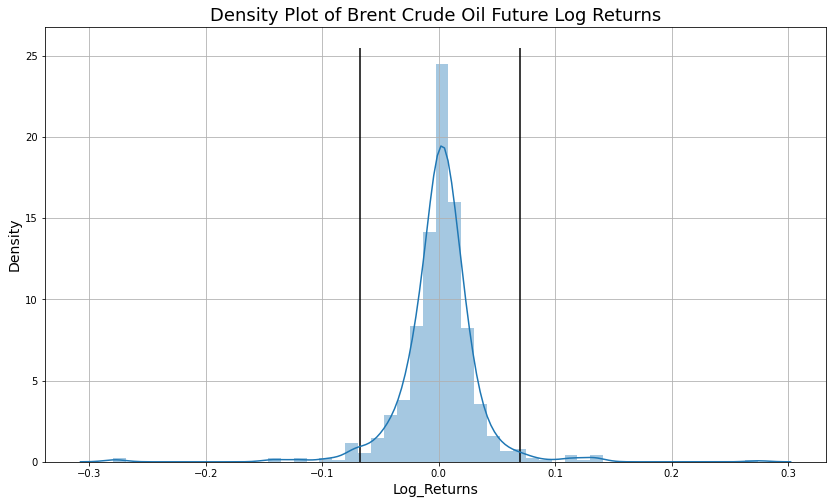

In [37]:
plt.figure(figsize=(14,8))
plt.title('Density Plot of Brent Crude Oil Future Log Returns', fontsize = 18)
plt.ylabel('Density', fontsize = 14)
plt.xlabel('Log Returns', fontsize = 14)
plt.grid(True)
plt.vlines(x=lb, ymin=0,ymax=25.5, color = 'black')
plt.vlines(x=ub, ymin=0,ymax=25.5, color = 'black')
sns.distplot(X)

In [ ]:
perf1 = np.squeeze(perf1) # Dimension Reduction
perf = np.squeeze(perf) # Dimension Reduction
perf1 = pd.Series(perf1)
perf = pd.Series(perf[1:])

[*********************100%***********************]  1 of 1 completed


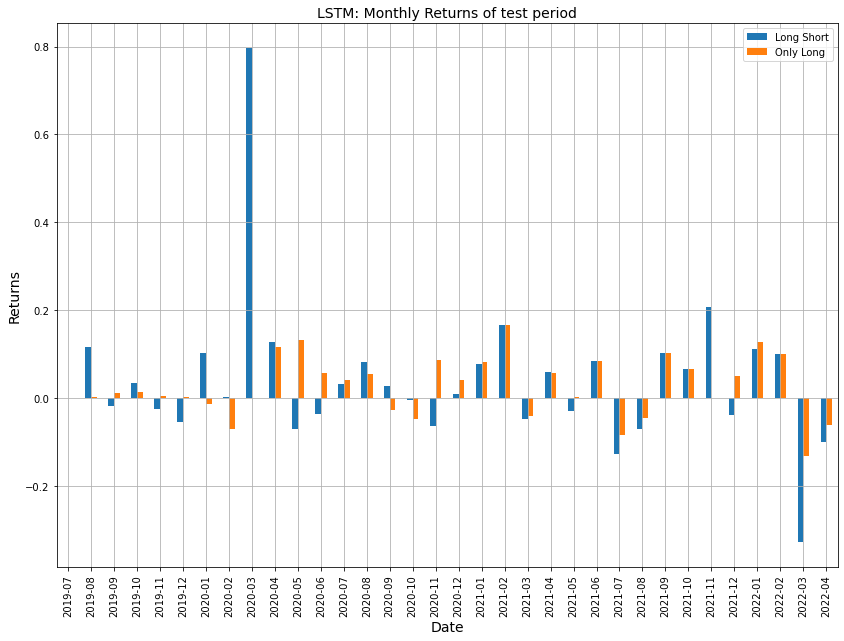

In [40]:
#Indexing
dat = yf.download('BZ=F', start='2007-08-16',end = "2022-04-26",period='1d')
end_len = len(dat["Close"])
long_short = np.exp(perf1).cumprod()
start_len = end_len - len(long_short)
index = dat["Close"][start_len:end_len].index
perf1.index = index
perf.index = index




#Create Monthly Returns Long Short
da = perf1.groupby([(perf1.index.year),(perf1.index.month)]).sum()


monthly_ret_LS = da.values
n = len(monthly_ret_LS)
monthly_ret_LS = pd.DataFrame(monthly_ret_LS,index = pd.date_range(start='6/1/2019', freq='M', periods=n))



#Create Monthly Returns Long
da1 = perf.groupby([(perf.index.year),(perf.index.month)]).sum()
monthly_ret_OL = da1.values
monthly_ret_OL = pd.DataFrame(monthly_ret_OL,index = pd.date_range(start='6/1/2019', freq='M', periods=n))



#Connect DF
mon_ret = pd.concat([monthly_ret_LS, monthly_ret_OL], axis=1)
mon_ret.columns = ["Long Short","Only Long"]



#x Axis
x_ax = pd.period_range('6/1/2019', '2022-04-30', freq='M').strftime('%Y-%m')
mon_ret.index = x_ax[1:]




#Plot the barplot



ax = mon_ret.plot.bar(figsize=(14,10), rot = 0)
plt.title("LSTM: Monthly Returns of test period",fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.xticks(rotation=90)
plt.ylabel('Returns', fontsize=14)
plt.legend(loc='best')
plt.grid()

# ----------------------------------------------------------------------------------------

# Time Series Cross Validation Backwards

In [ ]:
#------------------------------------------------------------------------------------------------------------#
#                                               Full Dataset                                                 |
#------------------------------------------------------------------------------------------------------------#
# t_0 <--------------------------------------------------------------------------------------------------> t_n


# K = 1
#------------------------------------------------------------------------------------------------------------#
#                     |                    |                    |       Train        |          Test         |
#------------------------------------------------------------------------------------------------------------#

# K = 2
#------------------------------------------------------------------------------------------------------------#
#                     |                    |       Train        |       Train        |          Test         |
#------------------------------------------------------------------------------------------------------------#

# K = 3
#------------------------------------------------------------------------------------------------------------#
#                     |        Train       |       Train        |       Train        |          Test         |
#------------------------------------------------------------------------------------------------------------#

# K = 4
#------------------------------------------------------------------------------------------------------------#
#       Train         |         Train      |        Train       |       Train        |           Test        |
#------------------------------------------------------------------------------------------------------------#

L_Sharpe_Ratios = []
LS_Sharpe_Ratios = []
seed(8)
tf.random.set_seed(8)

for k in range (1,5): 
    L1 = round(len(X)*0.2)
    X_test = X[-L1:]
    y_test = y[-L1:]
    train1 = X[:-L1]
    train2 = y[:-L1]
    
    L2 = int(round(len(train1)*0.25*k))

    X_train = train1[-L2:]
    y_train = train2[-L2:]

    # Convert the X_train and y_train to numpy arrays 
    X_train, y_train = np.array(X_train), np.array(y_train)

    # Reshape the data
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    # X_train.shape

    # Convert the data to a numpy array
    X_test = np.array(X_test)

    # Reshape the data
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1 ))

    model.fit(X_train, y_train, batch_size=1, epochs=5)

    # Get the models predicted price values 
    predictions = model.predict(X_test)
    predictions = scaler.inverse_transform(predictions) # back-transform Prediction 

    y_pred = pd.DataFrame(predictions)

    y_r = y_pred.pct_change() # Predicted Returns from Test data
    y1 = (y_r > 0).astype(int) # Predicted low risk Signal
    
    n = len(y1)
    X2 = bco['Log_Returns']
    X2 = X2[len(X2)-n:]

    perf = y1.T.values * X2.values
    
    trading_days_Y = 5*52 

    perf_sharpe = np.sqrt(trading_days_Y) * np.mean(perf) / (np.sqrt(np.var(perf)))
    L_Sharpe_Ratios.append(perf_sharpe)
    
    y3 = np.sign(y_r)
    y3 = y3[1:]
    X2 = X2[1:]
    perf1 = y3.T.values * X2.values
    perf_sharpe1 = np.sqrt(trading_days_Y) * np.mean(perf1) / (np.sqrt(np.var(perf1)))
    LS_Sharpe_Ratios.append(perf_sharpe1)

In [ ]:
# create data
data = [["Only Long", round(L_Sharpe_Ratios[0],2), round(L_Sharpe_Ratios[1],2),
         round(L_Sharpe_Ratios[2],2), round(L_Sharpe_Ratios[3],2)], 
        ["Long Short", round(LS_Sharpe_Ratios[0],2), round(LS_Sharpe_Ratios[1],2),
         round(LS_Sharpe_Ratios[2],2), round(LS_Sharpe_Ratios[3],2)]]
  
#define header names
col_names = ["K = 1", "K = 2", "K = 3", "K = 4"]
  
#display table
print('LSTM')
print('Cross Validation Time Series Split Backward')
print('Sharpe Ratio')
print(tabulate(data, headers=col_names))

In [ ]:
print('Mean Only Long Sharpe Ratio = ',round(np.mean(L_Sharpe_Ratios),2))
print('Mean Long Short Sharpe Ratio = ',round(np.mean(LS_Sharpe_Ratios),2))

# ----------------------------------------------------------------------------------------

# Time Series Cross Validation Forwards

In [ ]:
#------------------------------------------------------------------------------------------------------------#
#                                               Full Dataset                                                 |
#------------------------------------------------------------------------------------------------------------#
# t_0 <--------------------------------------------------------------------------------------------------> t_n


# K = 1
#------------------------------------------------------------------------------------------------------------#
#        Train        |       Test         |                    |                    |                       |
#------------------------------------------------------------------------------------------------------------#

# K = 2
#------------------------------------------------------------------------------------------------------------#
#        Train        |       Train        |      Test          |                    |                       |
#------------------------------------------------------------------------------------------------------------#

# K = 3
#------------------------------------------------------------------------------------------------------------#
#        Train        |       Train        |      Train         |        Test        |                       |
#------------------------------------------------------------------------------------------------------------#

# K = 4
#------------------------------------------------------------------------------------------------------------#
#        Train        |       Train        |      Train         |        Train       |       Test            |
#------------------------------------------------------------------------------------------------------------#


L_Sharpe_Ratios = []
LS_Sharpe_Ratios = []
seed(8)
tf.random.set_seed(8)

for k in range (2,6):
    
    L1 = round(len(X)*0.2*k)
    L2 = round(len(X)*0.2)
    X_t = X[:L1]
    y_t = y[:L1]

    X_train = X_t[:-L2]
    X_test = X_t[-L2:]
    y_train = y_t[:-L2]
    y_test = y_t[-L2:]
    

    # Convert the X_train and y_train to numpy arrays 
    X_train, y_train = np.array(X_train), np.array(y_train)

    # Reshape the data
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    # X_train.shape

    # Convert the data to a numpy array
    X_test = np.array(X_test)

    # Reshape the data
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1 ))

    model.fit(X_train, y_train, batch_size=1, epochs=5)

    # Get the models predicted price values 
    predictions = model.predict(X_test)
    predictions = scaler.inverse_transform(predictions) # back-transform Prediction 

    y_pred = pd.DataFrame(predictions)

    y_r = y_pred.pct_change() # Predicted Returns from Test data
    y1 = (y_r > 0).astype(int) # Predicted low risk Signal
    
    n = len(y1)
    X2 = bco['Log_Returns']
    X2 = X2[len(X2)-n:]

    perf = y1.T.values * X2.values
    
    trading_days_Y = 5*52 

    perf_sharpe = np.sqrt(trading_days_Y) * np.mean(perf) / (np.sqrt(np.var(perf)))
    L_Sharpe_Ratios.append(perf_sharpe)
    
    y3 = np.sign(y_r)
    y3 = y3[1:]
    X2 = X2[1:]
    perf1 = y3.T.values * X2.values
    perf_sharpe1 = np.sqrt(trading_days_Y) * np.mean(perf1) / (np.sqrt(np.var(perf1)))
    LS_Sharpe_Ratios.append(perf_sharpe1)

In [ ]:
# create data
data = [["Only Long", round(L_Sharpe_Ratios[0],2), round(L_Sharpe_Ratios[1],2),
         round(L_Sharpe_Ratios[2],2), round(L_Sharpe_Ratios[3],2)], 
        ["Long Short", round(LS_Sharpe_Ratios[0],2), round(LS_Sharpe_Ratios[1],2),
         round(LS_Sharpe_Ratios[2],2), round(LS_Sharpe_Ratios[3],2)]]
  
#define header names
col_names = ["K = 1", "K = 2", "K = 3", "K = 4"]
  
#display table
print('LSTM')
print('Cross Validation Time Series Split Forward')
print('Sharpe Ratio')
print(tabulate(data, headers=col_names))

In [ ]:
print('Mean Only Long Sharpe Ratio = ',round(np.mean(L_Sharpe_Ratios),2))
print('Mean Long Short Sharpe Ratio = ',round(np.mean(LS_Sharpe_Ratios),2))

# ----------------------------------------------------------------------------------------

# K-Fold Cross Validation

In [ ]:
#------------------------------------------------------------------------------------------------------------#
#                                               Full Dataset                                                 |
#------------------------------------------------------------------------------------------------------------#
# t_0 <--------------------------------------------------------------------------------------------------> t_n


# K = 1
#------------------------------------------------------------------------------------------------------------#
#        Test         |       Train         |       Train       |       Train        |         Train         |
#------------------------------------------------------------------------------------------------------------#

# K = 2
#------------------------------------------------------------------------------------------------------------#
#        Train        |       Test          |       Train       |       Train        |         Train         |
#------------------------------------------------------------------------------------------------------------#

# K = 3
#------------------------------------------------------------------------------------------------------------#
#        Train        |       Train         |       Test        |       Train        |         Train         |
#------------------------------------------------------------------------------------------------------------#

# K = 4
#------------------------------------------------------------------------------------------------------------#
#        Train        |       Train         |       Train       |       Test         |         Train         |
#------------------------------------------------------------------------------------------------------------#

# K = 5
#------------------------------------------------------------------------------------------------------------#
#        Train        |       Train         |       Train       |       Train        |         Test          |
#------------------------------------------------------------------------------------------------------------#

L_Sharpe_Ratios = []
LS_Sharpe_Ratios = []
Acc_score = []
seed(8)
tf.random.set_seed(8)

for k in range (1,6):
    
    L1 = int(round(len(X))*0.20*k)+1 # Geben
    L2 = int(round(len(X))*0.20*(k-1)) # Entfernen
    
    X_test = X[L2:L1]
    X_train = X.drop(index=X_test.index)
    
    y_test = y[L2:L1]
    y_train = y.drop(index=y_test.index)

    # Convert the X_train and y_train to numpy arrays 
    X_train, y_train = np.array(X_train), np.array(y_train)

    # Reshape the data
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    # X_train.shape

    # Convert the data to a numpy array
    X_test = np.array(X_test)

    # Reshape the data
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1 ))

    model.fit(X_train, y_train, batch_size=1, epochs=5)

    # Get the models predicted price values 
    predictions = model.predict(X_test)
    predictions = scaler.inverse_transform(predictions) # back-transform Prediction 

    y_pred = pd.DataFrame(predictions)
    
    y_r = y_pred.pct_change() # Predicted Returns from Test data
    y1 = (y_r > 0).astype(int) # Predicted low risk Signal
    
    n = len(y1)
    X2 = bco['Log_Returns']
    X2 = X2[len(X2)-n:]
    
    X1 = (X2 > 0).astype(int) # Real low risk Signal
    
    Acc_score.append(accuracy_score(X1, y1) * 100.0)

    perf = y1.T.values * X2.values
    
    trading_days_Y = 5*52 

    perf_sharpe = np.sqrt(trading_days_Y) * np.mean(perf) / (np.sqrt(np.var(perf)))
    L_Sharpe_Ratios.append(perf_sharpe)
    
    y3 = np.sign(y_r)
    y3 = y3[1:]
    X2 = X2[1:]
    perf1 = y3.T.values * X2.values
    perf_sharpe1 = np.sqrt(trading_days_Y) * np.mean(perf1) / (np.sqrt(np.var(perf1)))
    LS_Sharpe_Ratios.append(perf_sharpe1)

In [ ]:
# create data
data = [["Only Long", round(L_Sharpe_Ratios[0],2), round(L_Sharpe_Ratios[1],2),
         round(L_Sharpe_Ratios[2],2), round(L_Sharpe_Ratios[3],2), round(L_Sharpe_Ratios[4],2)], 
        ["Long Short", round(LS_Sharpe_Ratios[0],2), round(LS_Sharpe_Ratios[1],2),
         round(LS_Sharpe_Ratios[2],2), round(LS_Sharpe_Ratios[3],2), round(LS_Sharpe_Ratios[4],2)],
        ["Accuracy", round(Acc_score[0],2), round(Acc_score[1],2),
         round(Acc_score[2],2), round(Acc_score[3],2), round(Acc_score[4],2)]]
  
#define header names
col_names = ["K = 1", "K = 2", "K = 3", "K = 4", "K = 5"]
  
#display table
print('LSTM')
print('K-Fold Cross Validation')
print('Sharpe Ratio')
print(tabulate(data, headers=col_names))

In [ ]:
print('Mean Only Long Sharpe Ratio = ',round(np.mean(L_Sharpe_Ratios),2))
print('Mean Long Short Sharpe Ratio = ',round(np.mean(LS_Sharpe_Ratios),2))
print('Mean Accuracy Score = ',round(np.mean(Acc_score),2))

In [ ]:
round(np.std(Acc_score),2)